# Not Hotdog

---

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(1)

%load_ext autoreload
%autoreload 2
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_(many functions were placed in `utils.py` in order to make the code cleaner and I will import them directly from that file)_

## Data loading and image representation

In [35]:
from PIL import Image

data_folder = "./data/"

path = data_folder + "hotdog/893996.jpg"

# read image
image = Image.open(path)

# resize image
height = 28
width = 28
image = image.resize((height, width))

# transform the image to array
image = np.array(image)

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [36]:
image.shape

(28, 28, 3)


We can visualize the loaded image using

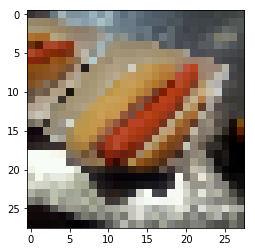

In [37]:
plt.figure(figsize=(4,4))
plt.imshow(image)

In [40]:
####### IMAGE AUGMENTATION

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        channel_shift_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
for image in img_hotdog:
    img = image.reshape((1,) + image.shape)  # this is a Numpy array with shape (1, color_channels, width, height)

    i = 0
    for batch in datagen.flow(img, batch_size=1,
                              save_to_dir='data/more_hotdogs/', save_prefix='hotdog_aug', save_format='jpg'):
        i += 1
        if i >= 7:
            break  # otherwise the generator would loop indefinitely

### Read images and resize them

I create a function inside `utils` to read images from a given path and resize them to have the every image on the dataset with the same width and height.

Use the defined `read_images_from_path` function to read and resize all training and test images.

In [41]:
from utils import read_images_from_path

# define paths
img_hotdog_path = data_folder + 'hotdog'
img_not_hotdog_path = data_folder + 'not_hotdog'
img_more_hotdog_path = data_folder + 'more_hotdogs'

# get images
img_hotdog = read_images_from_path(img_hotdog_path, height, width)
img_not_hotdog = read_images_from_path(img_not_hotdog_path, height, width)

img_hotdog = img_hotdog + read_images_from_path(img_more_hotdog_path, height, width)

Getting images from path: ./data/hotdog...
Getting images from path: ./data/not_hotdog...
Getting images from path: ./data/more_hotdogs...


Create `X_train`, `Y_train`, `X_test` and `Y_test` partitions.

In [42]:
from sklearn.model_selection import train_test_split

test_split_size = 0.2

img_hotdog_train, img_hotdog_test, \
tag_hotdog_train, tag_hotdog_test = train_test_split(img_hotdog,
                                                     len(img_hotdog) * [0],
                                                     test_size=test_split_size,
                                                     random_state=1)

img_not_hotdog_train, img_not_hotdog_test, \
tag_not_hotdog_train, tag_not_hotdog_test = train_test_split(img_not_hotdog,
                                                             len(img_not_hotdog) * [1],
                                                             test_size=test_split_size,
                                                             random_state=1)

In [43]:
X_train = np.asarray(img_hotdog_train + img_not_hotdog_train)
Y_train = np.asarray(tag_hotdog_train + tag_not_hotdog_train)

X_test = np.asarray(img_hotdog_test + img_not_hotdog_test)
Y_test = np.asarray(tag_hotdog_test + tag_not_hotdog_test)

#print(X_train[0].shape)
#print(Y_train)

If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [44]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

class_names = ['Hot dog', 'Not hot dog']

X_train size 2978
Y_train size 2978
X_test size 746
Y_test size 746


Show some **Hot dog** images:

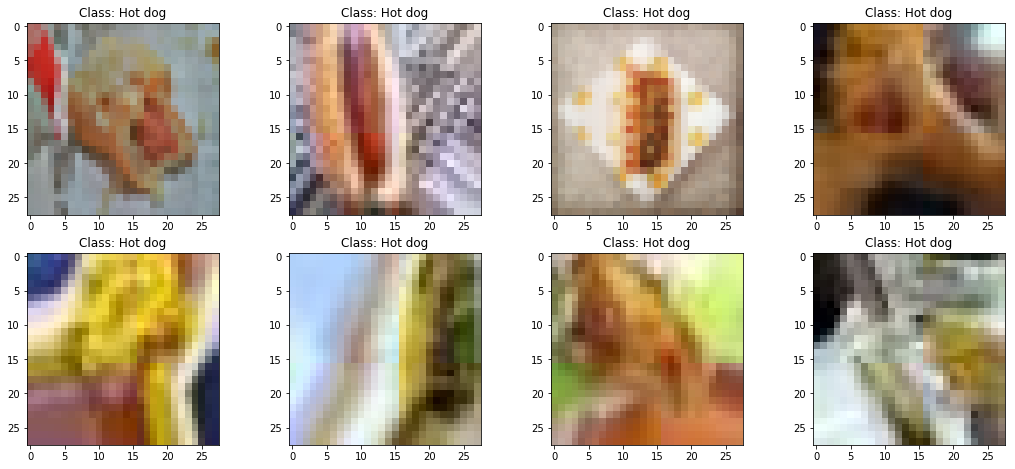

In [45]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

Show some **Not hot dog** images:

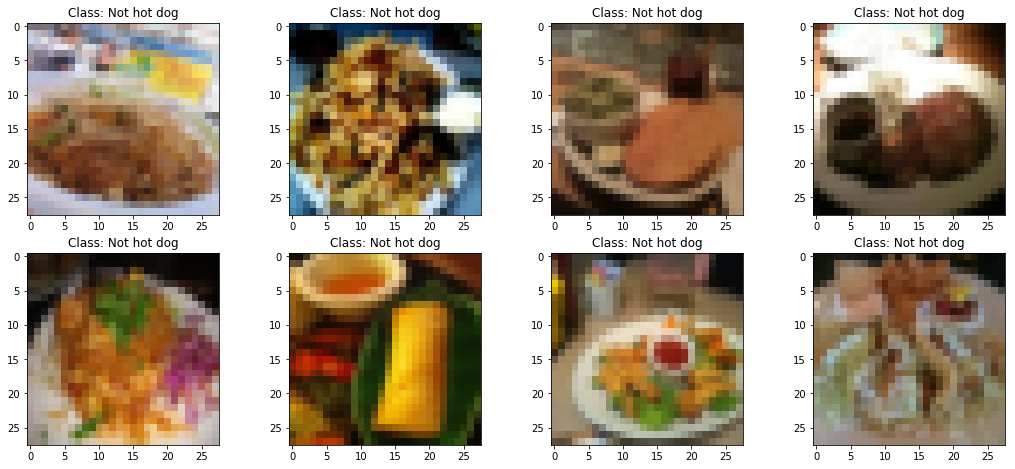

In [46]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i + len(img_hotdog_train)
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

## Data preprocessing

For efficiency in batch processing, in keras all input patterns should have equal dimensions. Even more, when working with images keras expects as training input a 4-dimensional matrix with dimensions (patterns, image_width, image_height, color_channels). Therefore, you must preprocess the data into this format. It is also highly recommended to rescale the pixel values to make them lie in the range [0,1]. Finally, you might also need to perform some transformation on the outputs Y.

In [47]:
from keras.utils import np_utils

# images are already resized to 30x40 pixels

# normalize data: rescale pixel values to the range [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# we should change the class encoding to something more akin to neural networks,
# instead of having a single integer ranging [0,1] to encode the different classes,
# we will use a one-hot vector encoder to codify that 2 classes
n_classes = 2

Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)

In [48]:
# preprocess the data into [patterns, image_width, image_height, color_channels] format
color_channels = X_train.shape[3]
train_patterns = X_train.shape[0]
test_patterns = X_test.shape[0]

train_tensor = X_train.reshape(train_patterns, width, height, color_channels)
test_tensor = X_test.reshape(test_patterns, width, height, color_channels)

print('train_tensor.shape: {}'.format(train_tensor.shape))
print('Y_train.shape: {}'.format(Y_train.shape))

print('test_tensor.shape: {}'.format(test_tensor.shape))
print('Y_test.shape: {}'.format(Y_test.shape))

train_tensor.shape: (2978, 28, 28, 3)
Y_train.shape: (2978, 2)
test_tensor.shape: (746, 28, 28, 3)
Y_test.shape: (746, 2)


## Deep model

Create a deep network that solves the classification problem using the layers that seem fit for problem.

### Convolutional network configuration

In [49]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Convolution1D, GlobalAveragePooling1D
from keras.optimizers import Adam


def build_model():
    model = Sequential()
    model.add(Conv2D(64, (1, 1), input_shape=(width, height, color_channels), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(2, 2)))

#    model.add(Conv2D(32, (1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#    model.add(Conv2D(64, (3, 3)))
#    model.add(Activation('relu'))
#    model.add(MaxPooling2D(pool_size=(2, 2)))
    # the model so far outputs 3D feature maps (height, width, features)

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

In [50]:
import numpy as np
np.random.seed(1) # for reproducibility

model = build_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              12846080  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 12,848,386
Trainable params: 12,848,386
Non-trainable params: 0
________________________________________________________________

In [ ]:
%%time

epochs = 25
batch_size = 32

model_history = model.fit(
    train_tensor,
    Y_train,
    steps_per_epoch = len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(test_tensor, Y_test),
    validation_steps = len(X_test) // batch_size,
    verbose=1
)

Train on 2978 samples, validate on 746 samples
Epoch 1/25
 5/93 [>.............................] - ETA: 11:25 - loss: 1.8424 - acc: 0.8325

In [ ]:
from utils import plot_loss_and_accuracy

score = model.evaluate(test_tensor, Y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

plot_loss_and_accuracy(model_history)

In this case adding more epochs ends making the model overfit (increasing the test loss), so I keep 20 epochs.

In [ ]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
preds = model.predict_classes(test_tensor)

Y_test_binary = np.argmax(Y_test,axis=1)
confusion_matrix = confusion_matrix(Y_test_binary, preds)

confusion_matrix

### Show some images for which the model fails

Although we've got a pretty good test accuracy, the remaining percentage of images may fail, out model is not 100% effective _–and these models don't exist–_.

In [ ]:
correct_predictions = preds == Y_test_binary
incorrect_images = test_tensor[~correct_predictions]
incorrect_images_index = [i for i, x in enumerate(correct_predictions) if not x]

plt.figure(figsize=(18, 36))
X_batch=[]

for i in range(0, 24):
    plt.subplot(8, 4, i+1)
    plt.imshow(incorrect_images[i])

    incorrect_image_pred_position = incorrect_images_index[i]
    incorrect_image_class = class_names[preds[incorrect_image_pred_position]]
    plt.title('Wrong class: {}'.format(incorrect_image_class))

# show the plot
plt.show()

---